## Massively parallel phage display panning against _P. aeruginosa_ cells, ordination plots (`fig-panning-massive`)

Note: the other portions of this figure are generated in the notebooks for `panning-massive`: [fig-panning-massive](../../../panning-massive/workflow/notebooks/fig-panning-massive.ipynb)

In [1]:
import nbseq
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import anndata

In [3]:
import plotly.express as px
import plotly.graph_objects as go

In [4]:
import nbseq.viz.ord
from nbseq.viz.ord import *

import nbseq.ordination

In [5]:
plt.rcParams.update({
    "font.family":"sans",
    'font.size': 5,
    'svg.fonttype':'none',
})

In [6]:
%config InlineBackend.figure_formats = ['svg']

In [7]:
ex_026m = nbseq.Experiment.from_files(directory='../panning-massive/',
                                      ft_aa=None,
                                      tree_cdr3=None, tree_aa=None) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')
ex_026m.fts.cdr3.obs['OprOP'] = np.nan

Loading experiment panning-massive from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from ../panning-massive/config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Warning: sqlite database '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive/intermediate/aa/asvs.db' does not exist
- Reading feature data for table 'cdr3' from ../panning-massive/results/tables/cdr3/asvs.csv (3.8 MB)...
- Reading cdr3 feature table from ../panning-massive/results/tables/cdr3/feature_table.biom (29.0 MB)...
- Warning: mmseqs2 database for space 'aa' at '../panning-massive/intermediate/aa/features_db/features' does not exist!
- Warning: mmseqs2 database for space 'cdr3' at '../panning-massive/intermediate/cdr3/features_db/features' does not exist!
- Reading enrichment model (conditional ECDF) for space cdr3 from ../panning-massive/results/tables/cdr3/enrichment/null/ecdf.pi

In [8]:
ex_026n = nbseq.Experiment.from_files(ft_aa=None,
                                 metadata='config/metadata_full.csv',
                                 tree_cdr3=None, tree_aa=None) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')

Loading experiment panning-extended from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-extended'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Using SQL database at 'sqlite:////vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-extended/intermediate/aa/asvs.db'
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (2.6 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (8.4 MB)...
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Using mmseqs2 database 'cdr3' at 'intermediate/cdr3/features_db/features'
- Reading enrichment model (conditional ECDF) for space cdr3 from results/tables/cdr3/enrichment/null/ecdf.pickle (307.6 kB)...
Finished in 0.30 seconds


Add/cleanup metadata

In [9]:
def cleanup_metadata(ex):

    nbseq.ft.add_metadata(ex.fts.cdr3, 'reads', 'nfeatures');
    # nbseq.ft.add_metadata(ex.fts.aa,   'reads', 'nfeatures');
    
    ex.fts.cdr3.obs['category'] = (ex.fts.cdr3.obs['category']
                                   .fillna('library')
                                   .replace({'alginate':'EPS', 'biofilm':'EPS', 'c-di-GMP':'EPS'}))
    
    ex.fts.cdr3.obs['background_CS'] = ex.fts.cdr3.obs.background_CS.fillna('N/A')
    ex.fts.cdr3.obs['background_S'] = ex.fts.cdr3.obs.background_S.fillna('N/A')
    
    ex.fts.cdr3.obs.loc[ex.fts.cdr3.obs['cond_S'].isna() & (ex.fts.cdr3.obs['expt'] == '027i.lib'),'cond_S'] = 'library'
    ex.fts.cdr3.obs['cond_S'] = ex.fts.cdr3.obs.cond_S.fillna('LB')
    ex.fts.cdr3.obs.loc[ex.fts.cdr3.obs['cond_CS'].isna() & (ex.fts.cdr3.obs['expt'] == '027i.lib'),'cond_CS'] = 'library'
    ex.fts.cdr3.obs['cond_CS'] = ex.fts.cdr3.obs.cond_CS.fillna('LB')
    
    
    make_growth_statement = lambda x: x if x in ['library', 'scrape'] else ('liquid stationary' if x == 'stationary' else 'liquid exponential')
    
    ex.fts.cdr3.obs['growth_S']  = ex.fts.cdr3.obs['cond_S'].apply(make_growth_statement)
    ex.fts.cdr3.obs['growth_CS'] = ex.fts.cdr3.obs['cond_CS'].apply(make_growth_statement)
    
    from nbseq.viz.utils import shorten_descriptions
    shorten_descriptions(ex.obs);
    shorten_descriptions(ex.fts.cdr3.obs);
    ex.fts.cdr3.obs['desc_short_ml'] = ex.fts.cdr3.obs['desc_short'].str.replace("/","\n")
    
    # ex.fts.aa.obs = ex.fts.cdr3.obs

    return ex

In [10]:
ex_026n = cleanup_metadata(ex_026n)
ex_026m = cleanup_metadata(ex_026m)

Load scran-normalized feature table

In [11]:
from pathlib import Path
def load_scran(ex, directory=".", query_last=""):
    ft_cdr3_norm = nbseq.ft.read(str(Path(directory) / 'results/tables/cdr3/transformed/scran/feature_table.biom'))
    ft_cdr3_norm = nbseq.ft.join_metadata(ft_cdr3_norm, ex.fts.cdr3.obs, axis='obs')
    ft_cdr3_norm.obs.index.name = 'ID'
    
    ft_cdr3_norm_last = nbseq.ft.query(ft_cdr3_norm, query_last, axis='sample')

    return ft_cdr3_norm, ft_cdr3_norm_last

In [12]:
ft_cdr3_026m, ft_cdr3_026m_last = load_scran(ex_026m,query_last='(expt == "027i.lib") | (r == 5 & kind == "+" & io == "i")', directory="../panning-massive/")
ft_cdr3_026n, ft_cdr3_026n_last = load_scran(ex_026n,query_last='(expt == "027j.lib") | (r == 8 & kind == "+" & io == "i")', directory=".")

In [13]:
def make_data_ordn(ordn, obs, fields, dims={0:'PC1', 1: 'PC2', 2: 'PC3'}, index_name='sample', biplot=False):
    """ Create Source Data file for ordination plots
    """
    if isinstance(dims, list):
        dims = { n:f'PC{n+1}' for n in dims }
        
    df_ordn = ordn.samples[list(dims.keys())].rename(columns=dims)
    if isinstance(fields, list):
        fields = dict(zip(fields, fields))

    
    df_obs = obs[list(fields.keys())]
    df = df_ordn.join(df_obs).rename(columns=fields)

    if biplot:
        df_biplot = ordn.biplot_scores[list(dims.keys())].rename(columns=dims, index=lambda x: f'{x} (biplot)')
        df = pd.concat([df, df_biplot]).fillna('')
    
    if not df.index.name:
        df.index.name = index_name
    return df

## All rounds

In [14]:
ftf_all_026m = nbseq.ft.query(ft_cdr3_026m,"(expt == '027i.lib') | (kind == '+' & io == 'i')", axis='obs')

# there's another experiment mixed in here; also omit re-sequenced samples from 027i
ftf_all_026n = nbseq.ft.query(ft_cdr3_026n,"(expt == '027j.lib') | (kind == '+' & io == 'i' & expt == '027j')", axis='obs')

ftf_all_026m.obs_names = '026m_' + ftf_all_026m.obs_names
ftf_all_026n.obs_names = '026n_' + ftf_all_026n.obs_names

In [15]:
ftf_all = anndata.concat([ftf_all_026m, ftf_all_026n], axis=0)
# ftf_all.obs_names_make_unique()

In [16]:
%%bash
mkdir -p results/plots/ord/
mkdir -p results/tables/figures/ord/

In [17]:
ord_skl_all_026m, ord_skbio_all_026m = nbseq.ordination.ordinate(ftf_all_026m, method='TSVD', **{ 'n_components':100 })

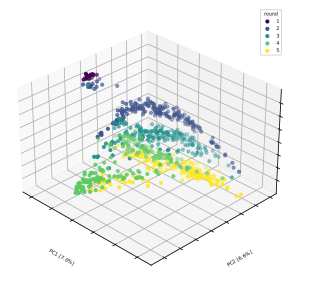

In [18]:
fig, ax = ordination_mpl(ord_skbio_all_026m, ftf_all_026m.obs, color='r',
                         s=10,
                         cmap=discrete_cmap(5,'viridis'), 
                         color_order=sorted(ftf_all_026m.obs['r'].unique()),
                         camera=dict(elev=30, azim=135, roll=0), 
                         fig_kw = dict(figsize=(6,5)));
plt.legend(title="round")
plt.savefig("results/plots/ord/panning-massive-rounds.svg")

(make_data_ordn(ord_skbio_all_026m, ftf_all_026m.obs, {'r':'round'})
 .to_csv('results/tables/figures/ord/panning-massive-rounds.csv', index=True))

In [19]:
ord_skl_all, ord_skbio_all = nbseq.ordination.ordinate(ftf_all, method='TSVD', **{ 'n_components':100 })

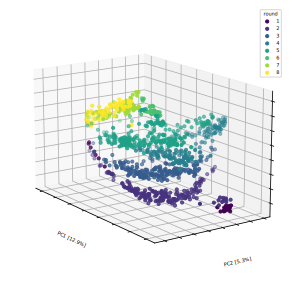

In [20]:
fig, ax = ordination_mpl(ord_skbio_all, ftf_all.obs, color='r',
                         s=10,
                         cmap=discrete_cmap(8,'viridis'), 
                         color_order=sorted(ftf_all.obs['r'].unique()),
                         camera=dict(elev=15, azim=-35, roll=0), 
                         fig_kw = dict(figsize=(6,5)));
plt.legend(title="round")
plt.savefig("results/plots/ord/panning-massive-extended-rounds.svg")

df = make_data_ordn(ord_skbio_all, ftf_all.obs, {'r':'round', 'expt':'panning'})
df['panning'].replace({'027i':'panning-massive', 
                       '027j':'panning-extended', 
                       '027i.lib': 'alpaca-library',
                       '027j.lib': 'alpaca-library'})
df.to_csv('results/tables/figures/ord/panning-massive-extended-rounds.csv', index=True)

In [21]:
ord_skl_all_026n, ord_skbio_all_026n = nbseq.ordination.ordinate(ftf_all_026n, method='TSVD', **{ 'n_components':100 })

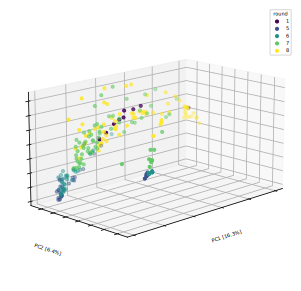

In [22]:
fig, ax = ordination_mpl(ord_skbio_all_026n, ftf_all_026n.obs, color='r',
                         s=10,
                         cmap=discrete_cmap(5,'viridis'), dims=[0,1,2],
                         color_order=sorted(ftf_all_026n.obs['r'].unique()),
                         camera=dict(elev=15, azim=45, roll=0), 
                         fig_kw = dict(figsize=(6,5)));
plt.legend(title="round")
plt.savefig("results/plots/ord/panning-extended-rounds.svg")

Uncomment to generate an interactive version of this plot using Plotly

In [23]:
# from natsort import natsorted
# fig = nbseq.viz.ord.ordination_plotly(ord_skbio_all_026n, ftf_all_026n.obs, color='r', 
#                                       hover_name='description', 
#                                       color_continuous_scale=px.colors.sequential.Viridis,
#                                       # color_discrete_sequence=px.colors.sequential.Viridis,
#                                       # category_orders={'r':natsorted(ftf_all_026n.obs['r'].unique())},
#                                       width=800,height=600)

# fig.update_traces(
#     marker_size=4,
#     marker_line_width=2,
#     marker_line_color='DarkSlateGrey',
#     overwrite=True
# )
# fig.update_layout(
#     legend= {'itemsizing': 'constant'},
#     scene_camera=dict(
#         eye=dict(x=-1, y=1, z=1),
#         center=dict(x=0, y=0, z=-0.2),
#     )
# )
# fig

## Filter samples taken over by CDR3s `ad6f8f` and `2c7c51`

In [24]:
bad_samples_oprM = ['027j.1.A2.1.R8i', '027j.1.C2.1.R8i', '027j.1.B6.1.R8i', '027j.1.C5.1.R8i']
bad_samples_oprN = ['027j.1.A4.1.R8i','027j.1.C4.1.R8i']
bad_samples_oprJ = ['027j.1.A3.1.R8i','027j.1.B3.1.R8i']
bad_samples = bad_samples_oprM + bad_samples_oprN + bad_samples_oprJ


In [25]:
# there's another experiment mixed in here; also omit re-sequenced samples from 027i (panning-massive)
ftf_good_026n = nbseq.ft.query(ft_cdr3_026n,
                               ("(expt == '027j.lib') | "
                                f"(kind == '+' & io == 'i' & expt == '027j' & ~(name_full in {bad_samples}))"), 
                               axis='obs')
ftf_good_026n.obs_names = '026n_' + ftf_good_026n.obs_names
ftf_all_good = anndata.concat([ftf_all_026m, ftf_good_026n], axis=0)


In [26]:
ord_skl_good_026n, ord_skbio_good_026n = nbseq.ordination.ordinate(ftf_all_026n, method='TSVD', **{ 'n_components':100 })

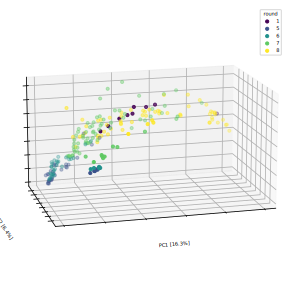

In [27]:
fig, ax = ordination_mpl(ord_skbio_good_026n, ftf_good_026n.obs, color='r',
                         s=10,
                         cmap=discrete_cmap(5,'viridis'), dims=[0,1,2],
                         color_order=sorted(ftf_all_026n.obs['r'].unique()),
                         camera=dict(elev=15, azim=75, roll=0), 
                         fig_kw = dict(figsize=(6,5)));
plt.legend(title="round")
plt.savefig("results/plots/ord/026n-rounds-filtered.svg")

In [28]:
ord_skl_good, ord_skbio_good = nbseq.ordination.ordinate(ftf_all_good, method='TSVD', **{ 'n_components':100 })

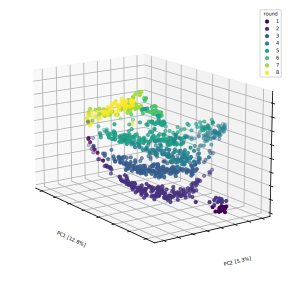

In [29]:
fig, ax = ordination_mpl(ord_skbio_good, ftf_all_good.obs, color='r',
                         s=10,
                         cmap=discrete_cmap(8,'viridis'), 
                         color_order=sorted(ftf_all.obs['r'].unique()),
                         camera=dict(elev=15, azim=-35, roll=0), 
                         fig_kw = dict(figsize=(6,5)));
plt.legend(title="round")
plt.savefig("results/plots/ord/026n-026m-rounds-filtered.svg")